# Machine Learning Model using Fruit 360 Dataset

## Imports
 
Here, import the required libraries for this project. Furthermore, we define some constants and also set our model to use mixed_precision

In [49]:
import tensorflow as tensorflowimport
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd 
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os, os.path
import csv
import tensorflow_hub as hub


policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

batch_size = 32
img_size = 100


## Testing Dataset

Here, we test to make sure the dataset loaded properly

(100, 100, 3)


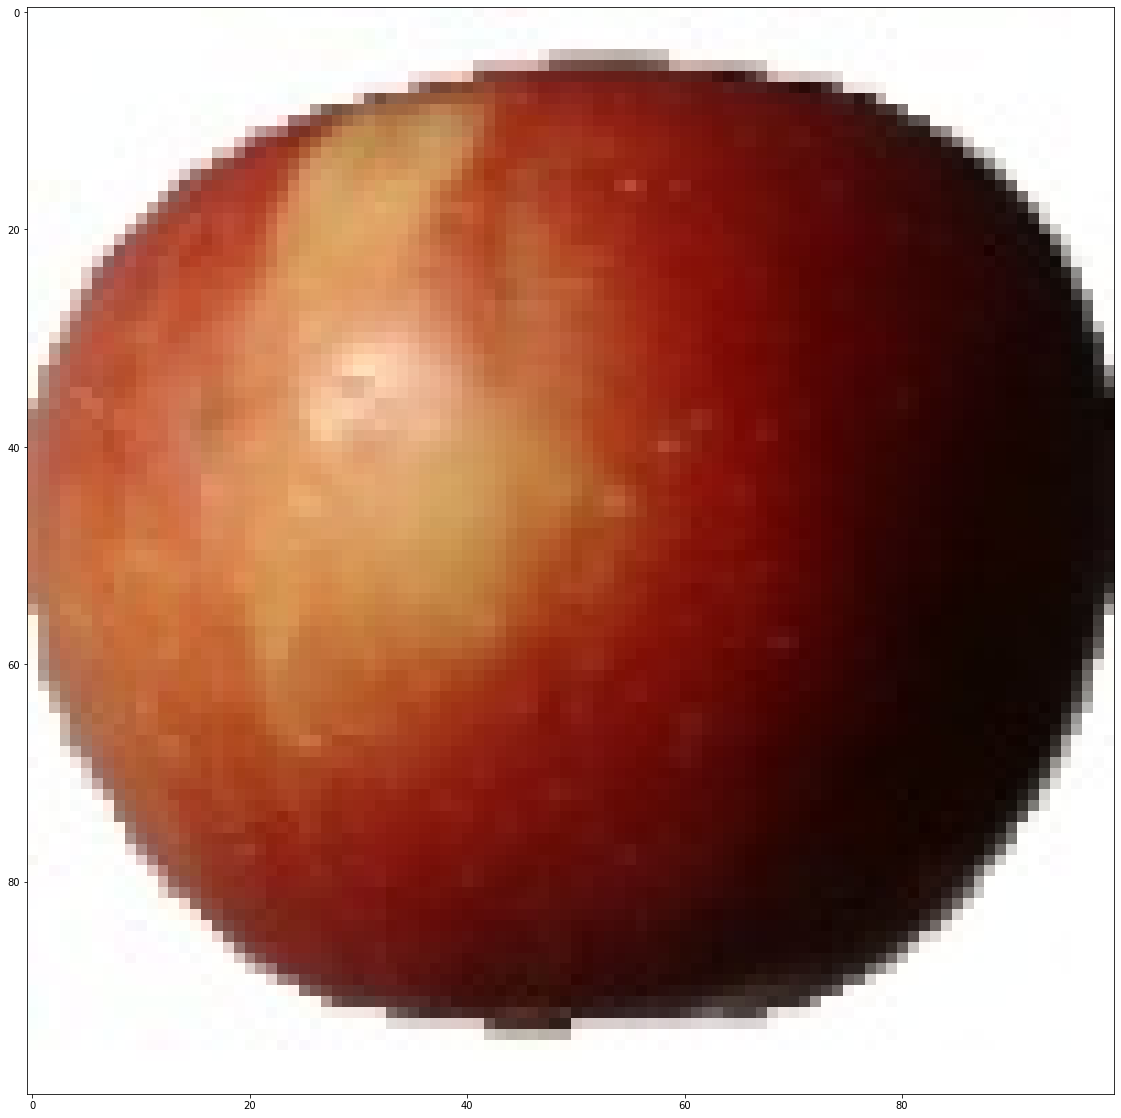

In [50]:
img = img.imread('FruitDataset/fruits-360_dataset/fruits-360/Training/Apple Braeburn/0_100.jpg')
print(img.shape)
plt.imshow(img)

## Dataset Information

We check to see how many images there are in the Training and Testing Set

In [51]:
train_categories = []
train_samples = []
train_path = 'FruitDataset/fruits-360_dataset/fruits-360/Training/'

for i in os.listdir(train_path):
    train_categories.append(i)
    train_samples.append(len(os.listdir(train_path+i)))

test_categories = []
test_samples = []
test_path = 'FruitDataset/fruits-360_dataset/fruits-360/Test/'
for i in os.listdir(test_path):
    test_categories.append(i)
    test_samples.append(len(os.listdir(test_path+i)))

print("Count of Fruits in Training set:", sum(train_samples))
print("Count of Fruits in Set set:", sum(test_samples))

Count of Fruits in Training set: 67692
Count of Fruits in Set set: 22688


Here we check the distribution of fruits in the training set

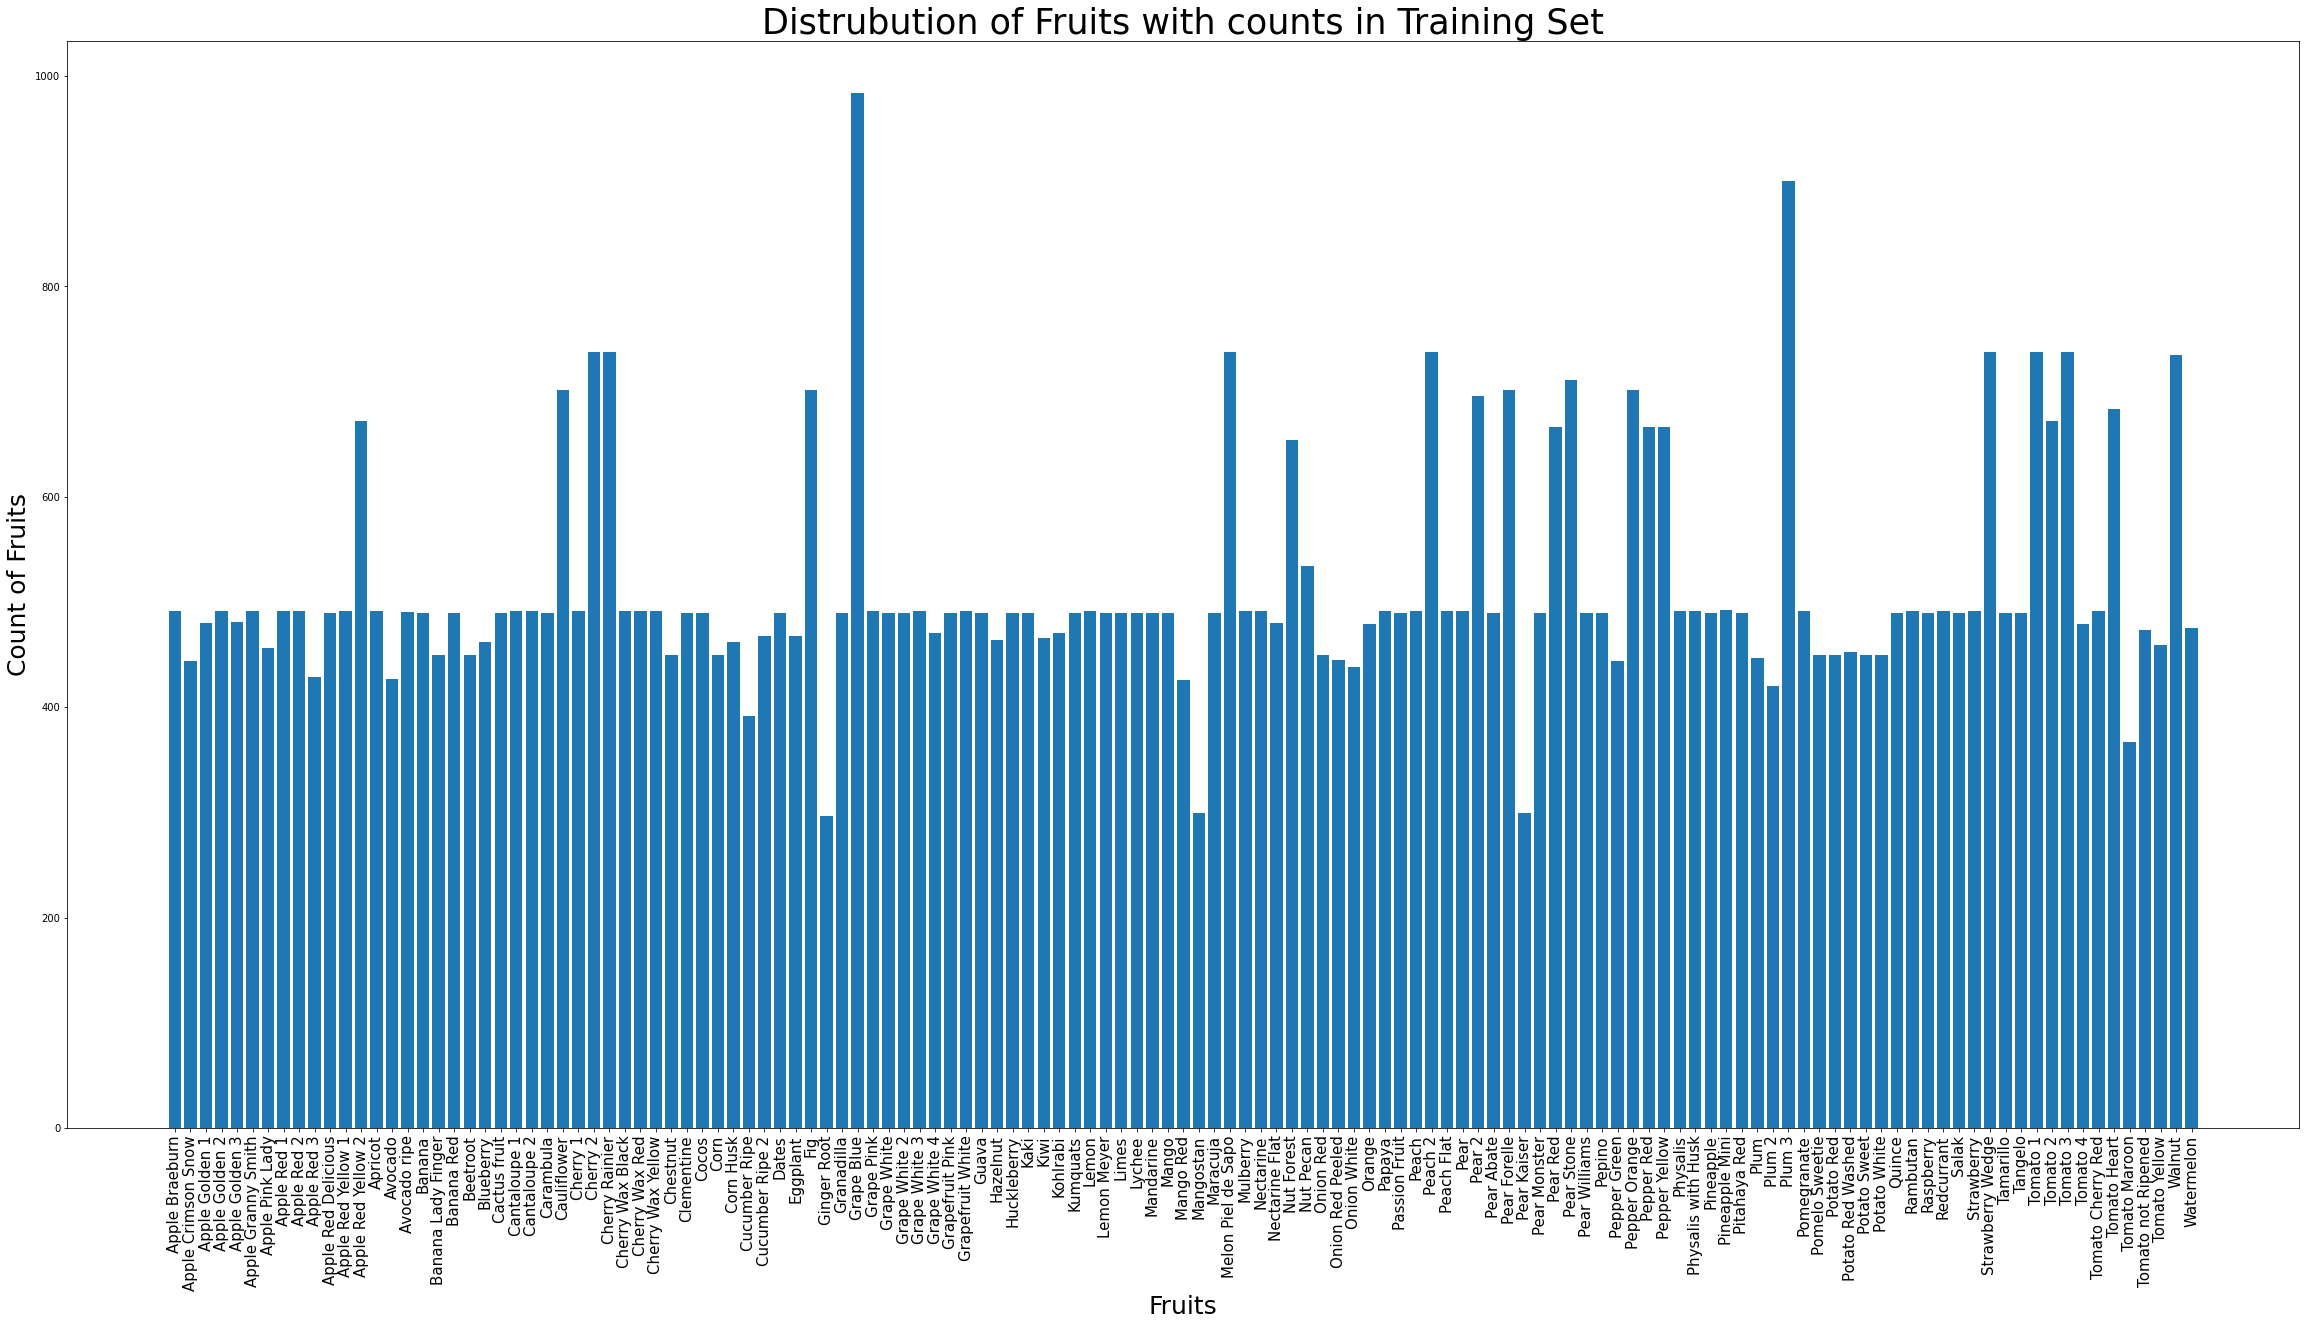

In [52]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size
index = np.arange(len(train_categories))
plt.bar(index, train_samples)
plt.xlabel('Fruits', fontsize=25)
plt.ylabel('Count of Fruits', fontsize=25)
plt.xticks(index, train_categories, fontsize=15, rotation=90)
plt.title('Distrubution of Fruits with counts in Training Set', fontsize=35)
plt.show()

Again for Test Set

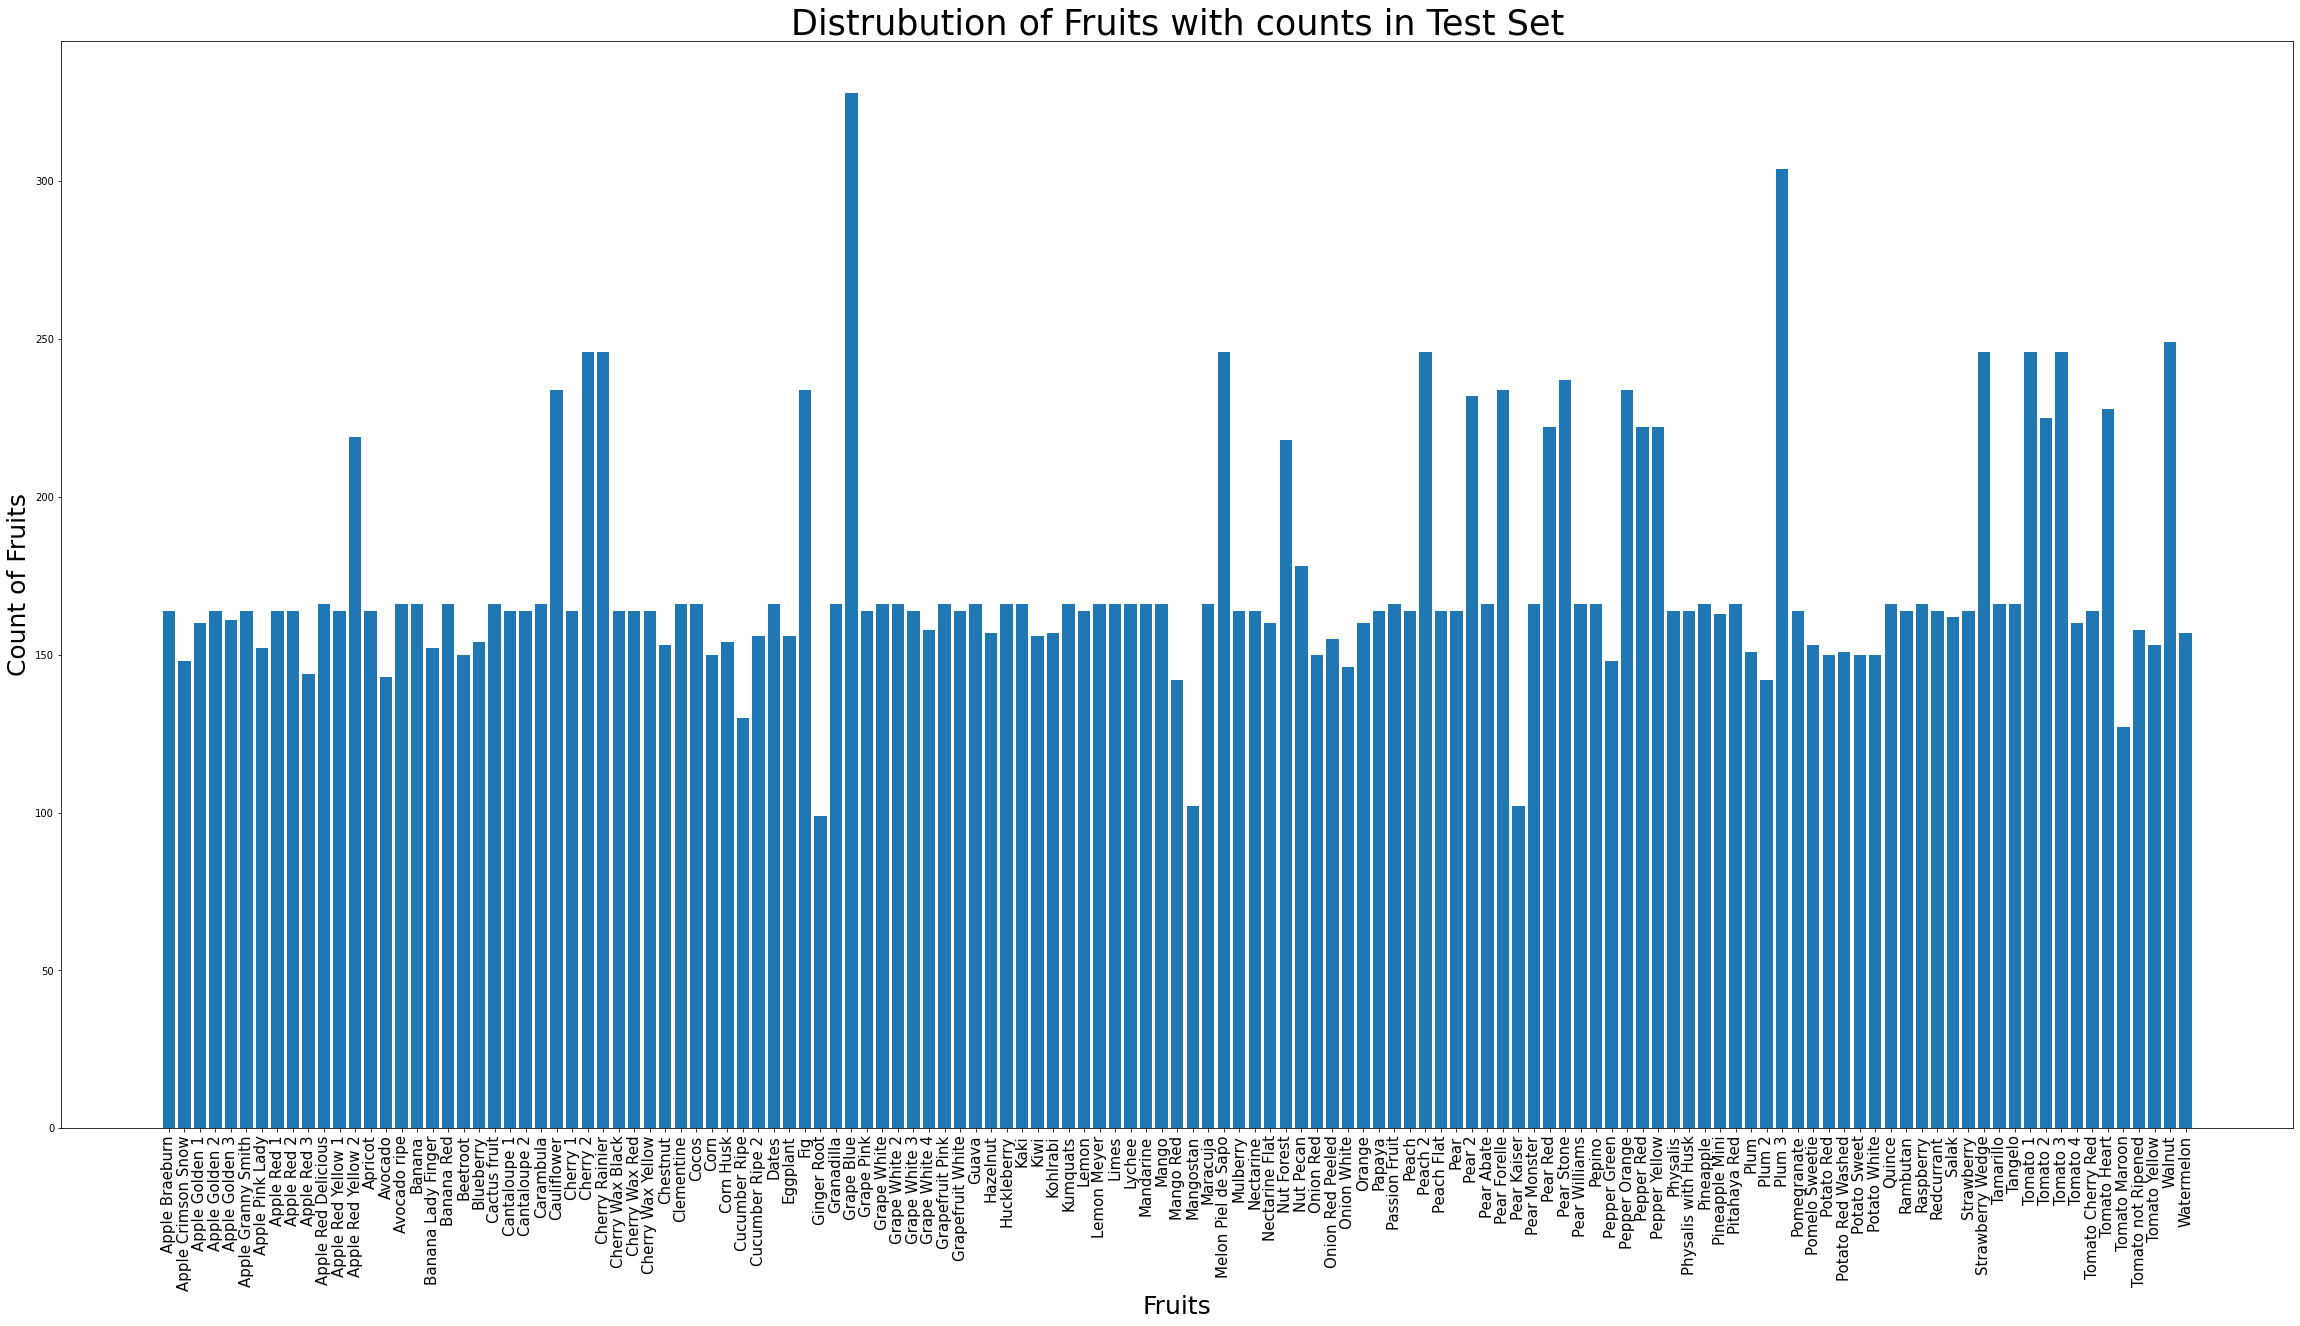

In [53]:
index2 = np.arange(len(test_categories))
plt.bar(index2, test_samples)
plt.xlabel('Fruits', fontsize=25)
plt.ylabel('Count of Fruits', fontsize=25)
plt.xticks(index2, test_categories, fontsize=15, rotation=90)
plt.title('Distrubution of Fruits with counts in Test Set', fontsize=35)
plt.show()

## Getting dataset from images

Here we will use the flow_from_directory function to help us get our dataset. This is because we have a lot of images and we won't have enough space in our memory to store them all. This function will let us store only the images we need in memory instead of all of them at once.

Furthermore, we will be using an ImageDataGenerator to perform data preprocessing

In [54]:
def get_dataset(path, batch_size):
    aug_gens = ImageDataGenerator(
        rescale=1./255, # normalize pixel values to [0,1]
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2
    )

    train_data = aug_gens.flow_from_directory(
        path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed = 1447)

    val_data = aug_gens.flow_from_directory(
        path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed = 1447)
    
    return train_data, val_data

def get_testdataset(path, batch_size):
    aug_gens = ImageDataGenerator(
        rescale=1./255, # normalize pixel values to [0,1]
    )
    
    test_data = aug_gens.flow_from_directory(
        path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        seed = 1447)

    return test_data
    

train, val = get_dataset('FruitDataset/fruits-360_dataset/fruits-360/Training', batch_size)
test = get_testdataset('FruitDataset/fruits-360_dataset/fruits-360/Test', batch_size)
    

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


Here we can see that the dataset generator initialized correctly

In [55]:
print(train.classes)
print(test.classes)

[  0   0   0 ... 130 130 130]
[  0   0   0 ... 130 130 130]


## Model

Here we will finally create our model!

We will start off with a very basic model to ensure everything is working!

In [56]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(img_size, img_size, 3)))
model.add(
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides = (1,1), padding = "same", activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1048, activation='swish'))
model.add(keras.layers.Dense(128, activation='swish'))
model.add(keras.layers.Dense(len(train_categories), activation='softmax'))

model.build(input_shape=(None, img_size, img_size, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 64)      

## Training

Now for the fun part. 

We first start off by compiling the model with the Adam optimizer, and set the number of epochs to 10. Then we fit the model and display the accuracies in a graph.

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train, workers = 8, epochs=num_epochs, validation_data=val, verbose = 1)

Epoch 1/10
1694/1694 [==============================] - 74s 42ms/step - loss: 1.0924 - accuracy: 0.6869 - val_loss: 0.5193 - val_accuracy: 0.8484
Epoch 2/10
1694/1694 [==============================] - 61s 36ms/step - loss: 0.1765 - accuracy: 0.9416 - val_loss: 0.5713 - val_accuracy: 0.8457
Epoch 3/10
1694/1694 [==============================] - 61s 36ms/step - loss: 0.1212 - accuracy: 0.9610 - val_loss: 0.3455 - val_accuracy: 0.9022
Epoch 4/10
1694/1694 [==============================] - 56s 33ms/step - loss: 0.1009 - accuracy: 0.9669 - val_loss: 0.2303 - val_accuracy: 0.9353
Epoch 5/10
1694/1694 [==============================] - 56s 33ms/step - loss: 0.0808 - accuracy: 0.9747 - val_loss: 0.2650 - val_accuracy: 0.9282
Epoch 6/10
1694/1694 [==============================] - 56s 33ms/step - loss: 0.0740 - accuracy: 0.9774 - val_loss: 0.2822 - val_accuracy: 0.9288
Epoch 7/10
1694/1694 [==============================] - 64s 38ms/step - loss: 0.0730 - accuracy: 0.9777 - val_loss: 0.1803 -

## Visualization

Here, we will visualize the accuracy of the model as it trains.

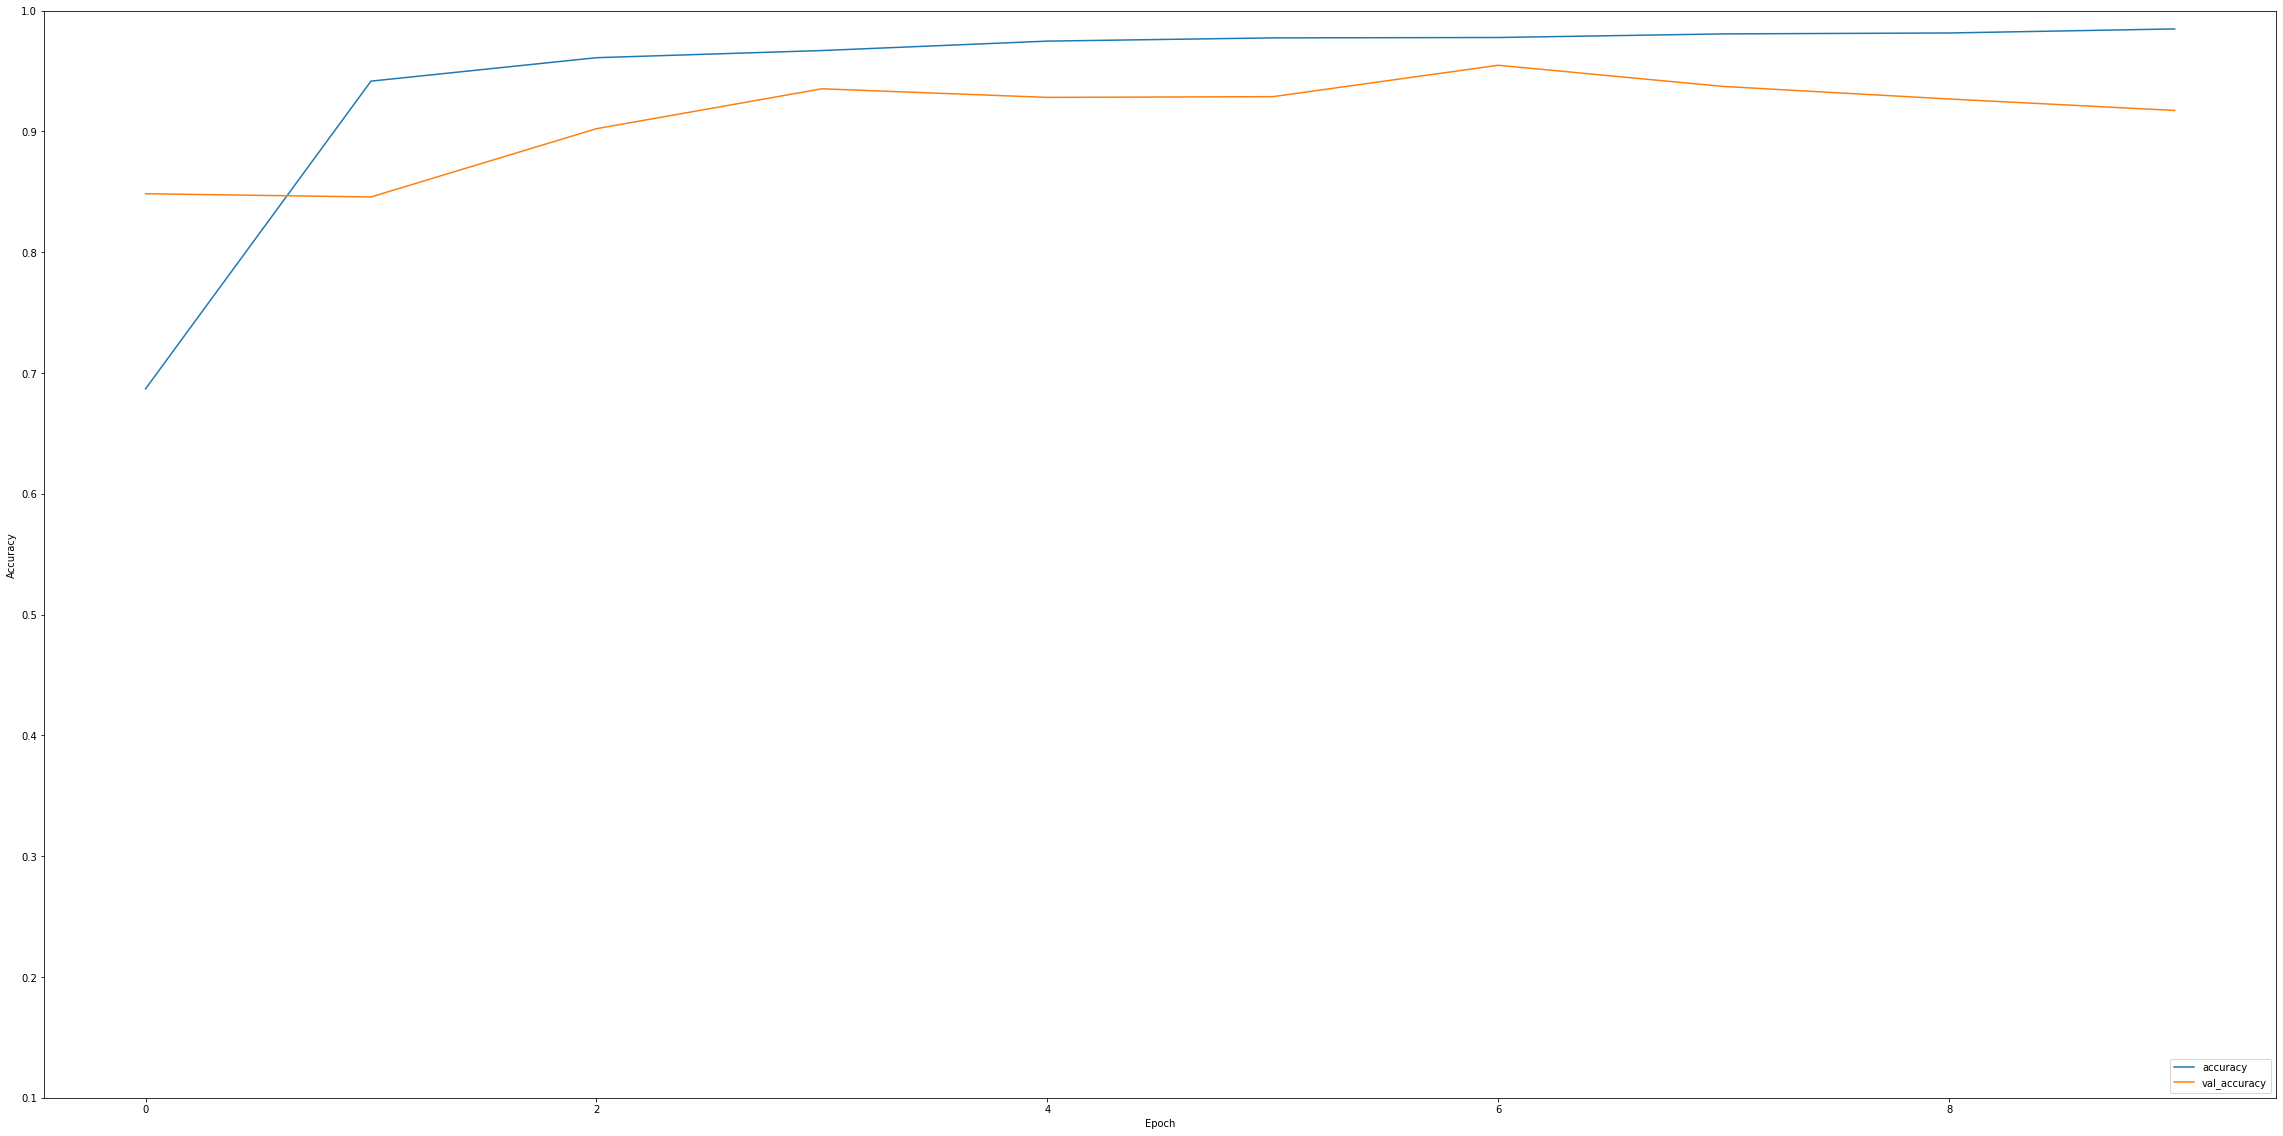

In [59]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

## Test data

Lets see how well our model does on the test data
In the end, we had a test accuracy of 94%
Pretty good for a basic model!

In [60]:
model.evaluate(test)

709/709 [==============================] - 17s 23ms/step - loss: 0.2675 - accuracy: 0.9439


[0.26746395230293274, 0.9438910484313965]